# Predict if pairs of questions from Quora contain two questions with the same semantics. 
Dataset: https://www.kaggle.com/c/quora-question-pairs/data

## Read the data

In [32]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from numpy.random import seed

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
from keras import activations
from keras import losses
from keras import metrics
from keras.utils import to_categorical
from keras.models import load_model
from keras import layers
from keras import activations
from keras import losses
from keras import optimizers
from keras import metrics
from keras import Input
from keras.models import Model
import keras.backend as K

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dfOriginal = pd.read_csv('train.csv')

In [3]:
dfOriginal.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [4]:
len(dfOriginal)

404290

In [5]:
dfOriginal.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
dfOriginal.dropna(axis=0, inplace=True)

In [7]:
len(dfOriginal)

404287

Example of two questions which share the same semantics.

In [8]:
dfOriginal['question1'][7], dfOriginal['question2'][7]

('How can I be a good geologist?', 'What should I do to be a great geologist?')

In [9]:
dfOriginal['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [10]:
df = dfOriginal.sample(n=10000)

In [11]:
len(df)

10000

In [12]:
df['is_duplicate'].value_counts()

0    6263
1    3737
Name: is_duplicate, dtype: int64

## Vectorize the dataset

Let's consider only the top 1000 words appearing in the questions.

In [13]:
maxWords = 1000

We need to decide what's the maximum length of the questions that we shall consider.

Let's get the sizes of each question.

In [14]:
sizeQuestionOne = df['question1'].str.len().tolist()
sizeQuestionTwo = df['question2'].str.len().tolist()

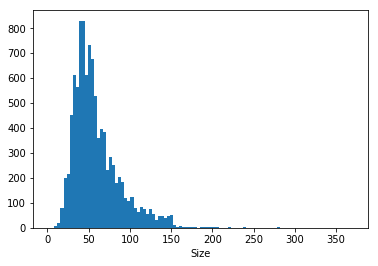

In [15]:
plt.hist(sizeQuestionOne,bins=100)
plt.xlabel('Size');

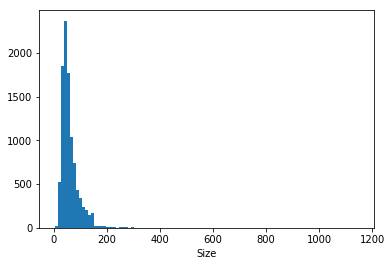

In [16]:
plt.hist(sizeQuestionTwo,bins=100)
plt.xlabel('Size');

In [17]:
min(sizeQuestionOne), min(sizeQuestionTwo), max(sizeQuestionOne), max(sizeQuestionTwo)

(1, 4, 370, 1151)

In [18]:
questionOne = np.asarray(df['question1'].astype(str).tolist(), dtype='object')
questionTwo = np.asarray(df['question2'].astype(str).tolist(), dtype='object')

**Process the labels**

In [19]:
labels = np.array(df['is_duplicate'].tolist())

In [20]:
indices = np.arange(len(df))
np.random.shuffle(indices)

In [21]:
questionOne = questionOne[indices]
questionTwo = questionTwo[indices]
labels = labels[indices]

**Tokenize the questions**

In [22]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(questionOne + questionTwo)
sequenceOne = tokenizer.texts_to_sequences(questionOne)
sequenceTwo = tokenizer.texts_to_sequences(questionTwo)

**Pad the questions**

In [23]:
maxQuestionSize = 150

In [24]:
dataOne = pad_sequences(sequenceOne, maxlen=maxQuestionSize)
dataTwo = pad_sequences(sequenceTwo, maxlen=maxQuestionSize)

In [25]:
dataOne.shape, dataTwo.shape

((10000, 150), (10000, 150))

In [26]:
labels.shape

(10000,)

## Split into training, validation and test set

In [27]:
trainingSetSize = 8000
validationSetSize = 1000

In [28]:
trainingSetOne = dataOne[:trainingSetSize]
trainingSetTwo = dataTwo[:trainingSetSize]
trainingLabels = labels[:trainingSetSize]

validationSetOne = dataOne[trainingSetSize: trainingSetSize + validationSetSize]
validationSetTwo = dataTwo[trainingSetSize: trainingSetSize + validationSetSize]
validationLabels = labels[trainingSetSize: trainingSetSize + validationSetSize]

testSetOne = dataOne[trainingSetSize + validationSetSize:]
testSetTwo = dataTwo[trainingSetSize + validationSetSize:]
testLabels = labels[trainingSetSize + validationSetSize:]

## Build the model
We will use a Siamese network in order to compute the similarity between the two questions.

A Siamese network consists of two identical neural networks or layers, each taking one of the two input questions. The last layers of the two networks are then fed to a contrastive loss function , which calculates the similarity between the two questions.

### Manhattan Distance

In [34]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

### Model

**Create the embedding layer**

In [78]:
embeddingDimensions = 150
embeddingLayer = layers.Embedding(embeddingDimensions, maxQuestionSize)

leftInput = Input(shape=(maxQuestionSize,), dtype='int32', name="questionOne")
rightInput = Input(shape=(maxQuestionSize,), dtype='int32', name="questionTwo")

embeddedQuestionOne = embeddingLayer(leftInput)
embeddedQuestionTwo = embeddingLayer(rightInput)

lstm = layers.Bidirectional(layers.LSTM(64))

leftOutput = lstm(embeddedQuestionOne)
rightOutput = lstm(embeddedQuestionTwo)

# Calculates the distance as defined by the MaLSTM model
distance = layers.Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), 
                        output_shape=lambda x: (x[0][0], 1))([leftOutput, rightOutput])

In [79]:
model = Model([leftInput, rightInput], distance)

In [80]:
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer,
             loss=losses.MSE,
             metrics=[metrics.binary_accuracy])

In [81]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
questionOne (InputLayer)        (None, 150)          0                                            
__________________________________________________________________________________________________
questionTwo (InputLayer)        (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 150, 150)     22500       questionOne[0][0]                
                                                                 questionTwo[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 128)          110080      embedding_11[0][0]               
          

In [93]:
history = model.fit([trainingSetOne, trainingSetTwo], 
                    trainingLabels, 
                    epochs=50, 
                    batch_size=64,
                    validation_data=([validationSetOne, validationSetTwo], validationLabels))

Train on 8000 samples, validate on 1000 samples
Epoch 1/50
8000/8000 [==============================] - 100s 12ms/step - loss: 0.1756 - binary_accuracy: 0.7728 - val_loss: 0.2203 - val_binary_accuracy: 0.6850
Epoch 2/50
8000/8000 [==============================] - 98s 12ms/step - loss: 0.1750 - binary_accuracy: 0.7719 - val_loss: 0.2186 - val_binary_accuracy: 0.6940
Epoch 3/50
8000/8000 [==============================] - 99s 12ms/step - loss: 0.1745 - binary_accuracy: 0.7756 - val_loss: 0.2197 - val_binary_accuracy: 0.6850
Epoch 4/50
8000/8000 [==============================] - 100s 12ms/step - loss: 0.1735 - binary_accuracy: 0.7720 - val_loss: 0.2189 - val_binary_accuracy: 0.6840
Epoch 5/50
8000/8000 [==============================] - 100s 12ms/step - loss: 0.1734 - binary_accuracy: 0.7766 - val_loss: 0.2192 - val_binary_accuracy: 0.6800
Epoch 6/50
8000/8000 [==============================] - 99s 12ms/step - loss: 0.1723 - binary_accuracy: 0.7781 - val_loss: 0.2195 - val_binary_accura

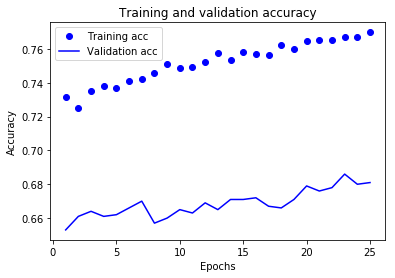

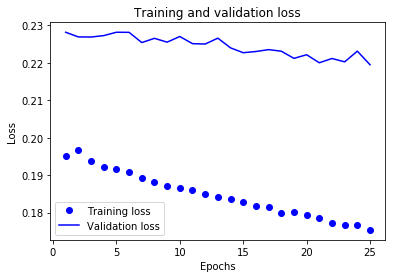

In [84]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Evaluate on test set

In [89]:
values = model.evaluate(x=[testSetOne, testSetTwo], y=testLabels)

1000/1000 [==============================] - 5s 5ms/step


In [91]:
print("Loss: " + str(values[0]))

Loss: 0.21182597386837004


In [92]:
print("Accuracy: " + str(values[1]))

Accuracy: 0.686


## Save the model and tokenizer

In [87]:
model.save("QQPairs.h5")

In [88]:
with open('QQTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)